In [73]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import math
from datetime import datetime
from scipy.stats import spearmanr
from scipy.stats import shapiro

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [74]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [75]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [76]:
# Подгрузим наши данные из соревнования

DATA_DIR = 'data'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'/hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [77]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [78]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [79]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [80]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [81]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [82]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [83]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

/var/folders/q_/7gwj_d0j19x6bt29_k4ngwl40000gq/T/ipykernel_13415/447817491.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем


## 1. Исследование структуры данных

## 1. Exploration of Data Structure.

Выведем информацию о датасете, чтобы пронализировать струкутуру данных

In [84]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [85]:
data.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,sample,reviewer_score
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,512470.000000,512470.000000,515738.000000,515738.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,49.442439,2.823803,0.749999,6.297672
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,3.466325,4.579425,0.433014,3.902295
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,41.328376,-0.369758,0.000000,0.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,48.214662,-0.143372,0.250000,0.625000
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,51.499981,0.010607,1.000000,7.900000
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,51.516288,4.834443,1.000000,9.600000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,52.400181,16.429233,1.000000,10.000000


В датасете 18 признаков, числовых из которых 10. Присутствуют признаки с нулевым значениями: lat и lng. 
Таким образом нам необходимо обработь текстовые признаки и заполнить пропуски. Перейдем к обработке данных и преобразованию признаков


The dataset has 18 features, 10 of which are numerical. There are features with zero values: "lat" and "lng". Therefore, we need to process the text features and fill in the missing values. Let's proceed with data processing and feature transformation.

## 2. Преобразование данных и создание новых признаков

## 2. Data Transformation and Feature Engineering.

Перед обработкой данных сделаем копию датасета, чтобы сохранить его на случай, если что-то пойдет не так :)

Before processing the data, let's make a copy of the dataset to preserve it in case something goes wrong :)

In [86]:
data_copy = data.copy()

Для начала заполним пропуски в признакак lat и lng. Проанализируем сколько уникальных адресов содержится в пустых строках. Если адресов немного, то мы сможем вручную найти широту и долготу и внести их в датасет.

To start, let's fill in the missing values in the lat and lng features. We'll analyze how many unique addresses are present in the empty strings. If there are only a few addresses, we can manually find their latitude and longitude and add them to the dataset.

In [87]:
print(data_copy[data_copy['lat'].isnull()]['hotel_address'].nunique()) 

data_copy[data_copy['lat'].isnull()]['hotel_address'].unique()

17


array(['W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria',
       'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria',
       '23 Rue Damr mont 18th arr 75018 Paris France',
       'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria',
       'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria',
       'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria',
       'Bail n 4 6 Eixample 08010 Barcelona Spain',
       'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria',
       '4 rue de la P pini re 8th arr 75008 Paris France',
       '20 Rue De La Ga t 14th arr 75014 Paris France',
       'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria',
       'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria',
       'Pau Clar s 122 Eixample 08009 Barcelona Spain',
       'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria',
       'Paragonstra e 1 11 Simmering 1110 Vienna Austria',
       'Hasenauerstra e 12 19 D bling 1190 Vienna Austria',
       'Sep lveda 180 Eix

Так как количество уникальных адресов всего 17, мной принято решение вручную найти широту и долготу каждого адреса и создать файл hotels_nan.csv. 
Далее я объединила две таблицы и заполнила пустые значения новыми, взятыми из открытых источников.

Since there are only 17 unique addresses, I have decided to manually find the latitude and longitude of each address and create a file called "hotels_nan.csv". Then, I merged the two tables and filled in the missing values with new ones taken from open sources.

In [88]:
hotels_nan = pd.read_csv('data/hotels_nan.csv', sep=';')
hotels_nan.head()

,hotel_address,lat,lng
0,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...,48.220412,16.355852
1,Gr nentorgasse 30 09 Alsergrund 1090 Vienna Au...,48.221016,16.366569
2,23 Rue Damr mont 18th arr 75018 Paris France,48.889078,2.333174
3,Josefst dter Stra e 10 12 08 Josefstadt 1080 V...,48.209385,16.353441
4,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,48.213583,16.380094


In [89]:
# Объединяем data и df_add по столбцу hotel_address
merged_data = data.merge(hotels_nan, on='hotel_address', how='left')

merged_data.head()
# Заполняем пропуски в lat и lng в merged_data
merged_data['lat_x'].fillna(merged_data['lat_y'], inplace=True)
merged_data['lng_x'].fillna(merged_data['lng_y'], inplace=True)

# Удаляем ненужные столбцы
merged_data.drop(['lat_y', 'lng_y'], axis=1, inplace=True)

merged_data.rename(columns={'lat_x': 'lat', 'lng_x':'lng'}, inplace=True)

data_copy = merged_data

Продолжим обработку данных с признака адрес отеля. Данный признак представлен типом object и содержит в себе строку. Мы можем сделать из строки список с помощью метода split. Выделим из адреса страну, в которой находится отель. Для этого напишем функцию country. Так как в нашем датасете есть страна United Kingdom, название которой состоит из двух слов, необходимо учесть это при написании функции

Let's start data processing from the "hotel address" feature. This feature is represented as an object type and contains a string. We can convert the string to a list using the split method. Let's extract the country where the hotel is located from the address. To do this, we will write a function called "country". Since our dataset includes the country "United Kingdom," which consists of two words, we need to take this into account when writing the function.

In [90]:
def country(address):
    lst = address.split(" ")
    if lst[-1] == 'Kingdom':
        return f'{lst[-2]} {lst[-1]}'
    else:
        return lst[-1]


#создаем новый признак country
data_copy['country'] = data_copy['hotel_address'].apply(country)

# выводим количество уникальных стран, для выбора способа преобразования
print(data_copy['country'].nunique())

6


Для того, чтобы выделить из адреса город отеля, нам так же необходимо учесть страну United Kingdom. Проверим сколько адресов содержит город Лондон и сверим с количеством вхождений значения "United Kingdom" в признаке country. Если количество будет совпадать, то мы можем заполнить признак city по стране United Kingdom одним значением London

To extract the city of the hotel from the address, we also need to take into account the country "United Kingdom." Let's check how many addresses contain the city of London and compare it with the number of occurrences of the value "United Kingdom" in the "country" feature. If the number of occurrences matches, we can fill in the "city" feature with one value "London" for the country "United Kingdom".

In [91]:
count = 0

for address in data_copy['hotel_address']:
    if 'London' in address:
        count += 1

result = abs(data[data_copy['country']=='United Kingdom'].shape[0] - count)

if result == 0:
    print('All hotels in United Kingdom are situated in London')
else:
    print(f'There are {result} hotels which situated in other cities')

All hotels in United Kingdom are situated in London


Теперь мы можем создать признак город

Now we can create a new feature called "city".

In [92]:
def city(address):
    lst = address.split(" ")
    if lst[-1] == 'Kingdom':
        return 'London'
    else:
        return lst[-2]

#создаем новый признак city 
data_copy['city'] = data_copy['hotel_address'].apply(city)

# выводим количество уникальных стран, для выбора способа преобразования
print(data_copy['city'].nunique())

6


Одним из самых важных признаков, которые могут влиять на рейтинг отеля, является его отдаленность от центра города. Так как у нас в датасете имеются признаки lat и lng, то мы можем найти координаты центров городов, входящих в датасет, и с помощью формулы гаверсинусов найти расстояние до центра города. Координаты центров городов я нашла вручную и занесла в таблицу city_center.

One of the most important features that can influence a hotel's rating is its distance from the city center. Since we have the "lat" and "lng" features in our dataset, we can find the coordinates of the city centers included in the dataset and use the haversine formula to calculate the distance to the city center. I manually found the coordinates of the city centers and recorded them in the "city_center" table.

In [93]:
city_center = pd.read_csv('data/city_center.csv', sep =';')
city_center.head()

,city,lat,lng
0,Milan,45.4642,9.1900
1,Amsterdam,52.3702,4.8952
2,Barcelona,41.3851,2.1734
3,London,51.5074,-0.1278
4,Paris,48.8566,2.3522


In [94]:
merged_city = data_copy.merge(city_center, on='city', how='left')

def distance(lat1, lon1, lat2, lon2):
    # Константа радиуса Земли в километрах
    R = 6371

    # Преобразование градусов в радианы
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    # Разница широты и долготы
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    # Формула гаверсинусов
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Расстояние между точками
    distance = R * c

    return distance


merged_city['distance_to_center'] = merged_city.apply(lambda row: distance(row['lat_x'], row['lng_x'], row['lat_y'], row['lng_y']), axis=1)

# Удаляем ненужные столбцы
merged_city.drop(['lat_y', 'lng_y'], axis=1, inplace=True)

merged_city.rename(columns={'lat_x': 'lat', 'lng_x':'lng'}, inplace=True)

data_copy = merged_city

United Kingdom    50.859351
Spain             11.662705
France            11.619853
Netherlands       11.093617
Austria            7.550151
Italy              7.214322
Name: country, dtype: float64
London       50.859351
Barcelona    11.662705
Paris        11.619853
Amsterdam    11.093617
Vienna        7.550151
Milan         7.214322
Name: city, dtype: float64


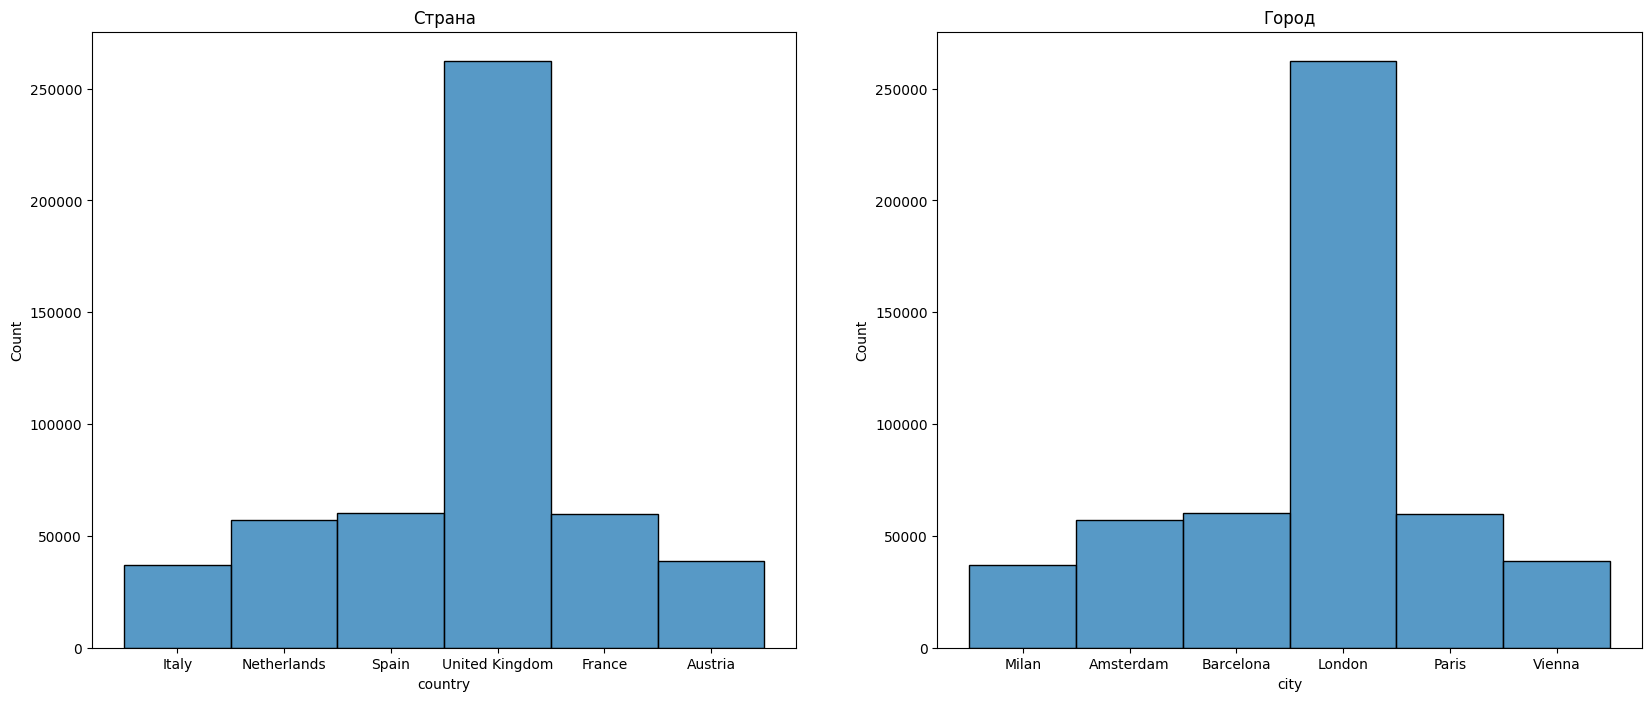

In [95]:
# Выводим информацию о соотношении стран в %
print(data_copy['country'].value_counts(normalize = True)*100)
print(data_copy['city'].value_counts(normalize = True)*100)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

sns.histplot(x='country', data=data_copy, ax=axes[0])
sns.histplot(x='city', data=data_copy, ax=axes[1])

axes[0].set_title('Страна');
axes[1].set_title('Город');

По графику видно, что мы имеем одинаковое количество значений по признакам country и city, и поэтому они имеют высокую корреляцию. Значит один из признаков необходимо удалить. Оставим признак country. Также сейчас мы можем удалить признак hotel_address, потому что мы взяли из него всю необходимую информацию.

Так как в датасете представлено только 6 стран, принято решение использовать метод кодирования OneHotEncoding.

Based on the plot, we can see that both the country and city features have the same number of values, indicating a high correlation between them. Therefore, one of these features needs to be removed. Let's keep the country feature. Furthermore, we can now remove the "hotel_address" feature since we have extracted all the necessary information from it.

As the dataset only includes 6 countries, the decision has been made to use the OneHotEncoding method for encoding. 

In [96]:
encoded_data = pd.get_dummies(data_copy['country'], prefix='country')
data_copy = pd.concat([data_copy, encoded_data], axis=1)

data_copy=data_copy.drop('city', axis=1)
data_copy=data_copy.drop('hotel_address', axis=1)
data_copy=data_copy.drop('country', axis=1)

data_copy.head()

,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,lng,sample,reviewer_score,distance_to_center,country_Austria,country_France,country_Italy,country_Netherlands,country_Spain,country_United Kingdom
0,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,...,9.171102,0,0.0,7.805692,0,0,1,0,0,0
1,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,...,4.834443,0,0.0,4.467612,0,0,0,1,0,0
2,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,...,2.161520,0,0.0,1.338573,0,0,0,0,1,0
3,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,...,9.196298,0,0.0,1.812239,0,0,1,0,0,0
4,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,...,4.888644,0,0.0,0.446745,0,0,0,1,0,0


Далее обработаем признак days_since_review. Данный признак представлен в формате string. Нам необходимо привести его к числовому формату.

Next, let's process the "days_since_review" feature. This feature is represented in the string format. We need to convert it to a numerical format.

In [97]:
def days_since_review(days):
    days_int = int(re.findall('[0-9]+', days)[0])
    return days_int

data_copy['days_since_review'] = data_copy['days_since_review'].apply(days_since_review)

data_copy['days_since_review'].head()

0     13
1    234
2    616
3    656
4    444
Name: days_since_review, dtype: int64

Теперь нам необходимо привести признак review_date к формату datetime и извлечь день недели, месяц, потому что они могут оказаться полезными при построении модели.

Now we need to convert the "review_date" feature to a datetime format and extract the day of the week and month, as they can be useful in model building.

In [98]:
data_copy['review_date'] = pd.to_datetime(data_copy['review_date'])

data_copy['review_day_of_the_week'] = data_copy['review_date'].dt.weekday

data_copy['review_month'] = data_copy['review_date'].dt.month

data_copy = data_copy.drop('review_date', axis=1)

data_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 25 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   hotel_name                                  515738 non-null  object 
 3   reviewer_nationality                        515738 non-null  object 
 4   negative_review                             515738 non-null  object 
 5   review_total_negative_word_counts           515738 non-null  int64  
 6   total_number_of_reviews                     515738 non-null  int64  
 7   positive_review                             515738 non-null  object 
 8   review_total_positive_word_counts           515738 non-null  int64  
 9   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 

Так как в датасете более 2000 уникальных наименований отелей, попробуем закодировать признак hotel_name методом Frequency Encoding, то есть создадим новый признак hotel_name_frequency с частотой встречаемости каждого значения признака hotel_name.

Since there are over 2000 unique hotel names in the dataset, let's try encoding the "hotel_name" feature using the Frequency Encoding method. In other words, we will create a new feature called "hotel_name_frequency" that represents the frequency of occurrence for each value in the "hotel_name" feature.

In [99]:
# Вычисление частоты встречаемости каждого значения признака 'hotel_name'
frequency = data_copy['hotel_name'].value_counts(normalize=True)

# Создание нового признака 'hotel_name_frequency', заменяющего 'hotel_name' на его частоту
data_copy['hotel_name_frequency'] = data_copy['hotel_name'].map(frequency)

# Удаление старого признака 'hotel_name'
data_copy.drop('hotel_name', axis=1, inplace=True)

Далее проанализируем признак reviewer_nationality. Проверим уникальные значения и сделаем вывод как лучше закодировать его.
Большую часть отзывов оставили граждане United Kingdom, поэтому это значение необходимо выделить в отдельную категорию. Так же выделим USA как отдельный признак, так как данное значение составляет более 5% от всех отзывов. 
Далее принято решение объединить европейские страны, за исключением United Kingdom, в отдельную категорию. Они составили 21% от всех значений. Оставшиеся страны пометим знаечением Other.
После обработки признака, создадим новые признаки с помощью OneHotEncoding.

Next, let's analyze the "reviewer_nationality" feature. We will check the unique values and draw conclusions on how to encode it effectively.
The majority of reviews were left by citizens of the United Kingdom, so this value should be highlighted as a separate category. Additionally, we will separate the USA as its own feature since it represents more than 5% of all reviews.
Furthermore, it has been decided to group European countries, excluding the United Kingdom, into a separate category. They account for 21% of all values. The remaining countries will be labeled as "Other."
After processing the feature, we will create new features using OneHotEncoding.

In [100]:
print(data_copy['reviewer_nationality'].value_counts(normalize=True))

data_copy['reviewer_nationality'] = data_copy['reviewer_nationality'].apply(lambda x: x.strip())

def nation(country):
    eu_countries = ["Russia", "Germany", "France", "Italy", "Spain", "Ukraine", "Poland", "Romania", "Netherlands", "Belgium", 
"Czech Republic", "Greece", "Portugal", "Sweden", "Hungary", "Belarus", "Austria", "Serbia", "Switzerland", "Bulgaria", 
"Denmark", "Finland", "Slovakia", "Norway", "Ireland", "Croatia", "Moldova", "Bosnia and Herzegovina", 
"Albania", "Lithuania", "North Macedonia", "Slovenia", "Latvia", "Estonia", "Montenegro", "Luxembourg", 
"Malta", "Iceland", "Andorra", "Monaco", "Liechtenstein", "San Marino", "Holy See"]
    
    if country == 'United Kingdom':
        return 'UK'
    elif country == 'United States of America':
        return 'USA'
    else:
        if country in eu_countries:
            return 'EU'
        else:
            return 'Other'

data_copy['reviewer_resid'] = data_copy['reviewer_nationality'].apply(nation)

print(data_copy['reviewer_resid'].value_counts(normalize=True))

encoded_data = pd.get_dummies(data_copy['reviewer_resid'], prefix='nation')
data_copy = pd.concat([data_copy, encoded_data], axis=1)

data_copy = data_copy.drop(['reviewer_nationality', 'reviewer_resid'], axis=1)

data_copy.head()

 United Kingdom               0.475524
 United States of America     0.068711
 Australia                    0.042048
 Ireland                      0.028749
 United Arab Emirates         0.019845
                                ...   
 Comoros                      0.000002
 Anguilla                     0.000002
 Tuvalu                       0.000002
 Cape Verde                   0.000002
 Palau                        0.000002
Name: reviewer_nationality, Length: 227, dtype: float64
UK       0.475524
Other    0.239926
EU       0.215838
USA      0.068711
Name: reviewer_resid, dtype: float64


,additional_number_of_scoring,average_score,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,...,country_Netherlands,country_Spain,country_United Kingdom,review_day_of_the_week,review_month,hotel_name_frequency,nation_EU,nation_Other,nation_UK,nation_USA
0,904,8.1,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13,...,0,0,0,4,7,0.003639,0,0,1,0
1,612,8.6,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234,...,1,0,0,0,12,0.002077,1,0,0,0
2,46,8.3,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616,...,0,1,0,3,11,0.000149,1,0,0,0
3,241,9.1,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656,...,0,0,0,5,10,0.000543,0,0,0,1
4,834,9.1,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444,...,1,0,0,0,5,0.003562,0,0,1,0


In [101]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 28 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   negative_review                             515738 non-null  object 
 3   review_total_negative_word_counts           515738 non-null  int64  
 4   total_number_of_reviews                     515738 non-null  int64  
 5   positive_review                             515738 non-null  object 
 6   review_total_positive_word_counts           515738 non-null  int64  
 7   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 8   tags                                        515738 non-null  object 
 9   days_since_review                           515738 non-null  int64  
 

В датасете присутствуют такие признаки как negative_review и positive_review формата object. На необходимо выяснить есть ли у отеля негативные и положительные отзывы. В признаках присутствуют значения "no negative", "nothing", "N A" и "no positive", написанных разными регистрами, поэтому нам нужно проделать нелегкую работу, чтобы определить положительный и отрицательный отзыв

The dataset includes features called "negative_review" and "positive_review" of the object type. We need to determine whether the hotel has negative and positive reviews. The features include values "no negative", "nothing", "N A" and "no positive" written in different cases, so we need to do some extra work to determine positive and negative reviews.

In [102]:
data_copy['negative_review'] = data_copy['negative_review'].apply(lambda x: x.strip())

def negative(review):
    non_negative = ['No Negative', 'Nothing', 'nothing', 'None', 'N A']
    if review in non_negative:
        return 0
    else:
        return 1

data_copy['negative_review'] = data_copy['negative_review'].apply(negative)

In [103]:
data_copy['positive_review'] = data_copy['positive_review'].apply(lambda x: x.strip())

def positive(review):
    non_positive = ['No Positive', 'Nothing', 'nothing', 'None', 'N A']
    if review in non_positive:
        return 0
    else:
        return 1
    
data_copy['positive_review']=data_copy['positive_review'].apply(positive)

In [105]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 28 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   negative_review                             515738 non-null  int64  
 3   review_total_negative_word_counts           515738 non-null  int64  
 4   total_number_of_reviews                     515738 non-null  int64  
 5   positive_review                             515738 non-null  int64  
 6   review_total_positive_word_counts           515738 non-null  int64  
 7   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 8   tags                                        515738 non-null  object 
 9   days_since_review                           515738 non-null  int64  
 

In [ ]:
data.nunique(dropna=False)

In [ ]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

In [ ]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

In [ ]:
data.info()

In [ ]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [ ]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

In [ ]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [ ]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [ ]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

In [ ]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

In [ ]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [ ]:
test_data.sample(10)

In [ ]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [ ]:
sample_submission

In [ ]:
predict_submission = model.predict(test_data)

In [ ]:
predict_submission

In [ ]:
list(sample_submission)

In [ ]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)